# Model Testing for Daily Fantasy Scores
Predict for the minimum and maximum winning scores for a slate

loading filename='lol-fanduel-CLASSIC-GPP.csv'
42 rows of data loaded
dropping 66 rows due to nan_slate_rows=33 nan_best_score_rows=33
9 rows


,date,style,type,top_score,last_winning_score,link,best-possible-score,slate_id,team_count,team-med,...,"('med-dfs', 'ADCB')","('med-dfs', 'JNG')","('med-dfs', 'MID')","('med-dfs', 'SUP')","('med-dfs', 'TOP')","('70.0th-pctl-dfs', 'ADCB')","('70.0th-pctl-dfs', 'JNG')","('70.0th-pctl-dfs', 'MID')","('70.0th-pctl-dfs', 'SUP')","('70.0th-pctl-dfs', 'TOP')"
3,2020-07-24,classic,GPP,561.55,520.93,https://www.fanduel.com/entry/ARPYYGDGQ,585.380700,346.0,8.0,1.5,...,67.409800,57.339999,62.210049,54.139602,55.540149,68.739960,73.143780,74.290188,57.499518,65.449832
8,2020-07-30,classic,GPP,675.29,530.69,https://www.fanduel.com/entry/BDXTOPBOB,677.370000,354.0,8.0,1.5,...,59.650000,50.580300,68.260248,36.090048,49.559799,78.853730,69.276010,90.926030,56.244050,65.979980
10,2020-07-01,classic,GPP,583.68,447.70,https://www.fanduel.com/entry/BLKTPTXIR,617.930000,311.0,8.0,1.5,...,62.869848,46.820051,45.390501,26.280000,48.110052,75.144020,58.551822,63.326050,57.040000,55.170040
14,2020-07-02,classic,GPP,606.02,558.68,https://www.fanduel.com/entry/CBZUAAZZG,642.410505,312.0,8.0,1.5,...,72.859801,77.999699,69.379851,47.499801,59.269951,83.600000,85.729758,81.267970,62.205880,74.965818
25,2020-07-12,classic,GPP,602.03,536.87,https://www.fanduel.com/entry/DBCWFEZMX,616.169602,329.0,8.0,1.5,...,76.959399,64.650450,72.810198,44.539698,65.240250,81.937852,70.011782,77.018000,51.708181,71.684020
28,2020-07-19,classic,GPP,689.52,633.64,https://www.fanduel.com/entry/DTVLQXWPN,698.649902,340.0,8.0,1.5,...,63.519801,51.049949,62.659900,35.779800,49.899950,83.185960,87.377990,80.251980,74.673970,78.256000
29,2020-06-25,classic,GPP,509.05,415.92,https://www.fanduel.com/entry/DUXRGIOZK,523.941692,301.0,8.0,1.5,...,52.729851,58.170149,60.810351,47.700198,53.340150,68.875980,61.214302,62.702382,48.072258,63.019970
30,2020-06-17,classic,GPP,585.46,478.60,https://www.fanduel.com/entry/DUXRMJEUZ,621.359703,291.0,8.0,1.5,...,69.589749,58.460049,66.000150,38.379999,53.550198,74.514178,71.167788,80.836020,61.177910,66.166040
35,2020-07-31,classic,GPP,638.75,560.35,https://www.fanduel.com/entry/EKKMWSHLJ,641.609100,355.0,8.0,1.5,...,65.569749,51.960249,70.459902,33.279702,48.709999,86.819640,64.110000,79.671900,39.600000,63.512000


Not enough training data available!
Not enough training data available!
loading filename='lol-fanduel-CLASSIC-FIFTY_FIFTY.csv'
36 rows of data loaded
dropping 48 rows due to nan_slate_rows=24 nan_best_score_rows=24
12 rows


,date,style,type,top_score,last_winning_score,link,best-possible-score,slate_id,team_count,team-med,...,"('med-dfs', 'ADCB')","('med-dfs', 'JNG')","('med-dfs', 'MID')","('med-dfs', 'SUP')","('med-dfs', 'TOP')","('70.0th-pctl-dfs', 'ADCB')","('70.0th-pctl-dfs', 'JNG')","('70.0th-pctl-dfs', 'MID')","('70.0th-pctl-dfs', 'SUP')","('70.0th-pctl-dfs', 'TOP')"
6,2020-07-24,classic,FIFTY_FIFTY,575.54,514.25,https://www.fanduel.com/entry/AOYLIDULC,585.380700,346.0,8.0,1.5,...,67.409800,57.339999,62.210049,54.139602,55.540149,68.739960,73.143780,74.290188,57.499518,65.449832
9,2020-07-19,classic,FIFTY_FIFTY,673.60,643.72,https://www.fanduel.com/entry/BFNLHRGDF,698.649902,340.0,8.0,1.5,...,63.519801,51.049949,62.659900,35.779800,49.899950,83.185960,87.377990,80.251980,74.673970,78.256000
10,2020-07-18,classic,FIFTY_FIFTY,569.97,479.21,https://www.fanduel.com/entry/BNOAKYZAK,672.750205,338.0,8.0,1.5,...,78.850000,68.070000,76.660000,42.320000,60.589950,97.352000,69.270000,77.924362,54.584000,65.799990
14,2020-07-12,classic,FIFTY_FIFTY,573.60,511.87,https://www.fanduel.com/entry/CHILEUFKL,616.169602,329.0,8.0,1.5,...,76.959399,64.650450,72.810198,44.539698,65.240250,81.937852,70.011782,77.018000,51.708181,71.684020
16,2020-07-23,classic,FIFTY_FIFTY,590.03,564.35,https://www.fanduel.com/entry/CLBUCRMAS,637.850144,343.0,8.0,1.5,...,64.429848,56.230049,66.859950,51.949850,66.300249,83.533970,66.172000,73.300040,69.466268,72.729508
18,2020-07-16,classic,FIFTY_FIFTY,627.42,588.84,https://www.fanduel.com/entry/DAOYOYIBX,649.820152,333.0,8.0,1.5,...,67.430101,50.720249,64.239600,52.500000,60.960000,81.097998,58.000542,73.465980,62.071880,77.622010
20,2020-06-25,classic,FIFTY_FIFTY,466.75,397.67,https://www.fanduel.com/entry/DDGWSYNFP,523.941692,301.0,8.0,1.5,...,52.729851,58.170149,60.810351,47.700198,53.340150,68.875980,61.214302,62.702382,48.072258,63.019970
21,2020-07-25,classic,FIFTY_FIFTY,466.05,414.88,https://www.fanduel.com/entry/DIPNDAURX,528.210297,347.0,8.0,1.5,...,61.699998,55.239600,59.459652,38.500101,53.930250,67.678460,67.971870,69.168128,44.262030,62.920058
23,2020-07-01,classic,FIFTY_FIFTY,525.92,440.04,https://www.fanduel.com/entry/DSGDFQIFT,617.930000,311.0,8.0,1.5,...,62.869848,46.820051,45.390501,26.280000,48.110052,75.144020,58.551822,63.326050,57.040000,55.170040
27,2020-07-17,classic,FIFTY_FIFTY,622.89,440.52,https://www.fanduel.com/entry/EHSZGBARH,685.130000,334.0,8.0,1.0,...,57.620000,48.840000,53.160000,39.880000,46.880000,82.842000,74.418000,86.518000,70.790000,74.104000



training model_name='top-score' model_cols=None
lol-fanduel-CLASSIC-FIFTY_FIFTY-top-score: model_cols=None
R2 score: 0.16830705703976034
RMSE score: 55.46441870840766
MAE score: 7.230054770086778

training model_name='last-win-score' model_cols=None
lol-fanduel-CLASSIC-FIFTY_FIFTY-last-win-score: model_cols=None
R2 score: -1.2859030272163485
RMSE score: 97.43086544549288
MAE score: 8.858855184098635
Explained variance = [9.22355841e-01 5.24844225e-02 1.96961084e-02 5.46362765e-03
 8.50357832e-32]
Singular varlues = [1.57072761e+02 3.74685457e+01 2.29531259e+01 1.20890500e+01
 4.76927630e-14]


'PCA data'

,0,1,2,3,4
0,8.846048,30.289177,9.026433,1.793851,1.651209e-14
1,-79.160158,-0.980637,-5.726865,-1.548614,1.345518e-14
2,38.954340,-9.918390,-5.053296,9.771113,2.002190e-14
3,-79.160158,-0.980637,-5.726865,-1.548614,1.345518e-14
4,102.356517,1.204489,-9.031942,-6.078441,1.704912e-14
5,8.163410,-19.614003,16.512534,-2.389293,2.289156e-14


,0,1,2,3,4
0,96.257280,0.929592,-3.429924,-3.300782,-2.969157
1,-23.773010,-5.588092,8.484461,1.389023,0.022100
2,-47.584479,-16.349605,27.447375,-5.375341,11.299670
3,-63.376919,7.526027,-5.549705,2.047081,4.193777
4,-52.646551,1.811719,6.761485,-0.765972,18.473111
5,-13.926424,-10.688319,3.403014,-0.588227,-0.910815


training model_name='top-score-pca' model_cols=None
lol-fanduel-CLASSIC-FIFTY_FIFTY-top-score-pca: model_cols=None
R2 score: 0.4855736223395335
RMSE score: 43.620895013281945
MAE score: 6.181385316772251
training model_name='last-win-score-pca' model_cols=None
lol-fanduel-CLASSIC-FIFTY_FIFTY-last-win-score-pca: model_cols=None
R2 score: -0.31192491276819156
RMSE score: 73.811180020761
MAE score: 8.321985822305706

training model_name='top-score' model_cols={'best-possible-score'}
lol-fanduel-CLASSIC-FIFTY_FIFTY-top-score: model_cols={'best-possible-score'}
R2 score: 0.11257807040302481
RMSE score: 57.29253461825973
MAE score: 6.888067011908551

training model_name='last-win-score' model_cols={'best-possible-score'}
lol-fanduel-CLASSIC-FIFTY_FIFTY-last-win-score: model_cols={'best-possible-score'}
R2 score: -0.5292582316290495
RMSE score: 79.69077902100847
MAE score: 8.414130179800976
Done


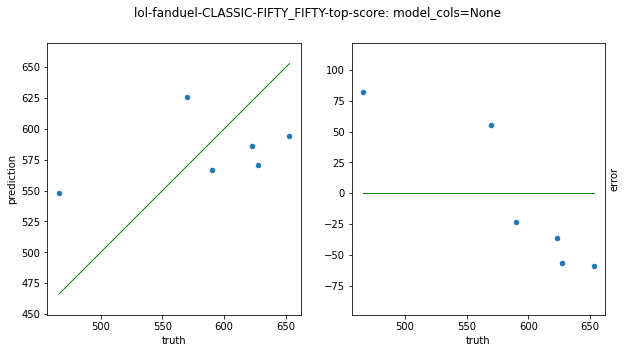

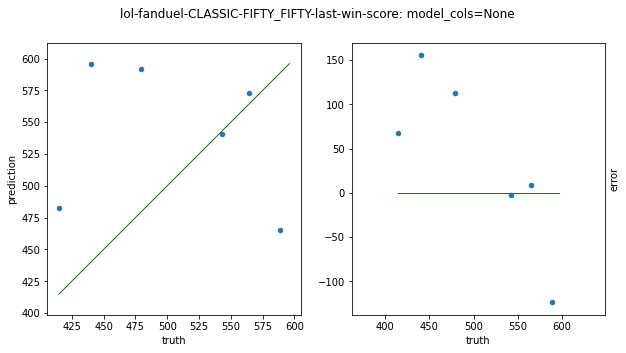

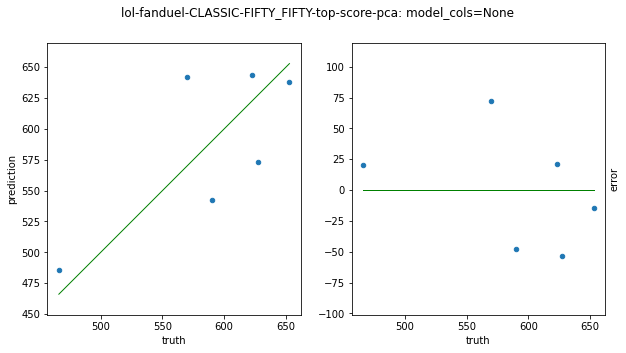

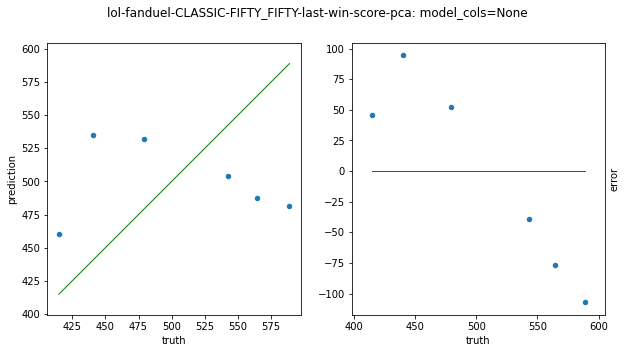

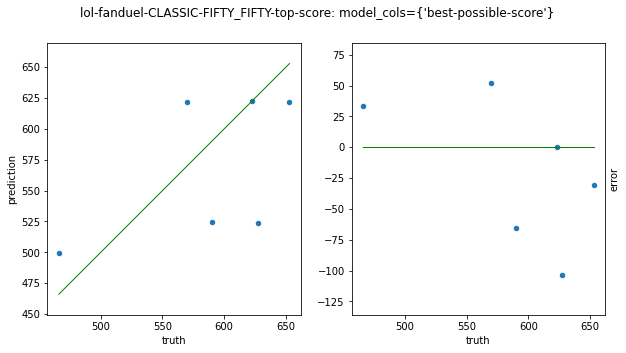

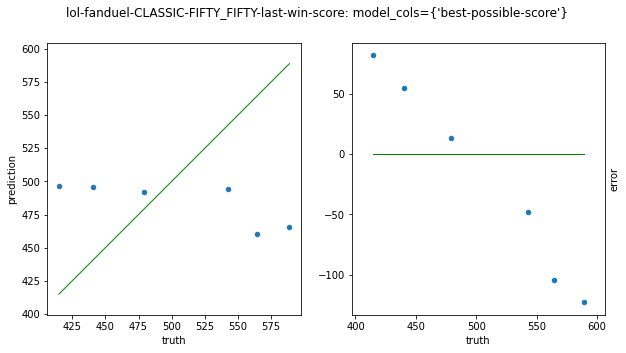

In [11]:
from generate_train_test import generate_train_test, load_csv
from automl import automl, error_report, pca_data

# normal test run
TRAIN_TIME = 600
PER_RUN_TIME_LIMIT = 120
STYLE = ContestStyle.CLASSIC

SPORT = 'lol'
SERVICE = 'fanduel'

PCA_COMPONENTS = 5

models = {}

for contest_type in [GeneralPrizePool, FiftyFifty]:
    df = load_csv(SPORT, SERVICE, STYLE, contest_type)
    # with pd.option_context('max_rows', 1000, 'max_columns', 100):
    #     print(f"{len(df)} rows")
    # display(df)        

    # generate 6 models, top and last winning score models 
    # using 1) all data columns, 2) pca reduction of all data and 3) just the best possible score
    for model_cols in [None, {'best-possible-score'}]:
        model_data = generate_train_test(
            df,
            model_cols=model_cols,
            random_state=5,
        )
        
        if model_data is None or len(model_data[0]) < 5:
            print("Not enough training data available!")
            continue
            
        (X_train, X_test, y_top_train, y_top_test,
         y_last_win_train, y_last_win_test) = model_data
        
        model_ys = [
            ('top-score', y_top_train, y_top_test), 
            ('last-win-score', y_last_win_train, y_last_win_test), 
        ]
        # models for top and last winning score
        for model_name, y_train, y_test in model_ys:
            print()
            print(f"training {model_name=} {model_cols=}")
            model, fit_params = automl(
                model_name, 
                train_time=TRAIN_TIME,
                per_run_time_limit=PER_RUN_TIME_LIMIT,
                seed=1,
                overwrite=True
            )
            model.fit(X_train, y_train, **fit_params)
            model_desc = f"{SPORT}-{SERVICE}-{STYLE.name}-{contest_type.NAME}-{model_name}: {model_cols=}"
            error_report(model, X_test, y_test, model_desc)
            models[model_desc] = model
            
        # pca models only when using multiple data columns
        if len(model_cols) == 1:
            continue
                
        for model_name, y_train, y_test in model_ys:
            model_name += '-pca'
            print(f"training {model_name=} {model_cols=}")
            model, fit_params = automl(
                , X_test_pca, y_test, model_name, 
                train_time=TRAIN_TIME,
                per_run_time_limit=PER_RUN_TIME_LIMIT,
                seed=1,
                overwrite=True,
                pca_components=PCA_COMPONENTS,
            )
            model.fit(X_train_pca, y_train, **fit_params)
            model_desc = f"{SPORT}-{SERVICE}-{STYLE.name}-{contest_type.NAME}-{model_name}: {model_cols=}"
            error_report(model, X_test_pca, y_test, model_desc)
            models[model_desc] = model
            
print("Done")